In [2]:
# excercise for deep learning class
# QUERY : smile recognition from images

In [3]:
# imports
import os
import tensorflow as tf

print('imports are done successfully')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

imports are done successfully


In [4]:
# using gpu
# tutorial : 3 dots on top right > accelerator > choosing gpu

# loading dataset from kaggle itself
# tutorial : https://www.youtube.com/watch?v=VaJEK6fycwM

In [5]:
# creating folder paths
total_data = r'/kaggle/input/genki4k/kaggle-genki4k'
train_dir = r'/kaggle/working/train'
validation_dir = r'/kaggle/working/validation'

# splitting train & validation data
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
# tf needs to know in what image size images should be read
# input of mobilenet should be 160 * 160

# creating train folder
train_folder = tf.keras.utils.image_dataset_from_directory(total_data,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            seed= 7,
                                                            validation_split= 0.3,
                                                            subset= 'training')

# creating validation folder
validation_folder = tf.keras.utils.image_dataset_from_directory(total_data,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 seed=7,
                                                                 validation_split= 0.3,
                                                                 subset= 'validation')

# Note: tf.keras.utils.image_dataset_from_directory : creates folders for train & validation,
# reads the source images itself & assings them to train or validation folders

# Note: we haven't still created test folder

Found 4000 files belonging to 2 classes.
Using 2800 files for training.
Found 4000 files belonging to 2 classes.
Using 1200 files for validation.


In [6]:
# deviding validation data to 2 parts, one for validation itself & one for test 

val_batches = tf.data.experimental.cardinality(validation_folder)
test_folder = validation_folder.take(val_batches // 5)
validation_folder = validation_folder.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_folder))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_folder))


Number of validation batches: 31
Number of test batches: 7


In [7]:
# this code helps to read the images faster
AUTOTUNE = tf.data.AUTOTUNE
train_folder = train_folder.prefetch(buffer_size=AUTOTUNE)
validation_folder = validation_folder.prefetch(buffer_size=AUTOTUNE)
test_folder = test_folder.prefetch(buffer_size=AUTOTUNE)


print('AUTOTUNE is done successfully')

AUTOTUNE is done successfully


In [8]:
# CREATING DIFFERENT PARTS OF MODEL

In [9]:
# step1 > data augmentation : increasing num of samples
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    # vertical is not suitable here
    tf.keras.layers.RandomRotation(0.2),
])

print('data augmentation is done successfully')

data augmentation is done successfully


In [10]:
# step2 > preprocessing with mobilenet
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
# divides the numbers by 127.5 and subtracts every one  by -1

# step3 > Create the base model using the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# Freeze the convolutional base
base_model.trainable = False

print('preprocessing with mobilenet is done successfully')

9406464/9406464 [==============================] - 1s 0us/step
preprocessing with mobilenet is done successfully


In [11]:
# step4 > GlobalAveragePooling : avg pooling + flatten
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

print('creating GlobalAveragePooling is done successfully')

creating GlobalAveragePooling is done successfully


In [12]:
# step5 > prediction_layer
prediction_layer = tf.keras.layers.Dense(1)
# last layer has one neuron because it's a 2 class question

print('creating prediction layer is done successfully')

creating prediction layer is done successfully


In [13]:
# finally the model!!!
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

print('model has been assembled successfully')

model has been assembled successfully


In [14]:
# compiling the model
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

print('model compiled successfully')

model compiled successfully


In [15]:
# creating early stopping
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta=0.03, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

print('early stopping is done successfully')

early stopping is done successfully


In [16]:
# model evaluation
initial_epochs = 100
loss0, accuracy0 = model.evaluate(validation_folder)
history = model.fit(train_folder,
                    epochs=initial_epochs,
                    callbacks=[early_stopping],
                    validation_data=validation_folder)

print('model fitted successfully')

31/31 [==============================] - 9s 41ms/step - loss: 0.7794 - accuracy: 0.4908
Epoch 1/100
88/88 [==============================] - 8s 41ms/step - loss: 0.7298 - accuracy: 0.5593 - val_loss: 0.6551 - val_accuracy: 0.6404
Epoch 2/100
88/88 [==============================] - 3s 37ms/step - loss: 0.6550 - accuracy: 0.6204 - val_loss: 0.6445 - val_accuracy: 0.6670
Epoch 3/100
88/88 [==============================] - 3s 38ms/step - loss: 0.6341 - accuracy: 0.6400 - val_loss: 0.6167 - val_accuracy: 0.6475
Epoch 4/100
88/88 [==============================] - 3s 35ms/step - loss: 0.6309 - accuracy: 0.6439 - val_loss: 0.6100 - val_accuracy: 0.6516
Epoch 5/100
88/88 [==============================] - 3s 36ms/step - loss: 0.6116 - accuracy: 0.6561 - val_loss: 0.6045 - val_accuracy: 0.6701
Epoch 6/100
88/88 [==============================] - 3s 36ms/step - loss: 0.5969 - accuracy: 0.6696 - val_loss: 0.5949 - val_accuracy: 0.6691
Epoch 7/100
88/88 [==============================] - 3s 35ms

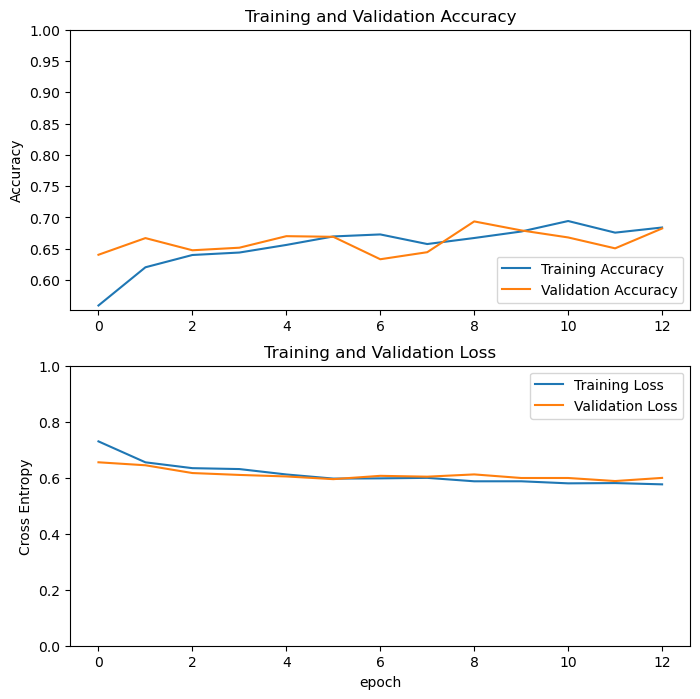

In [17]:
# plotting train & validation accuracy plot
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
